#### Step 1 导入相关包

In [1]:
import numpy as np
import pandas as pd
import pickle
from itertools import combinations
from collections import defaultdict

import matplotlib.pyplot as plt
# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'

import seaborn as sns
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

#### Step 2 加载数据

In [2]:
with open('./semantics_data/id2_affiliation_entity_filted.pickle','rb') as file:
    paper_affiliation_entity = pickle.load(file)

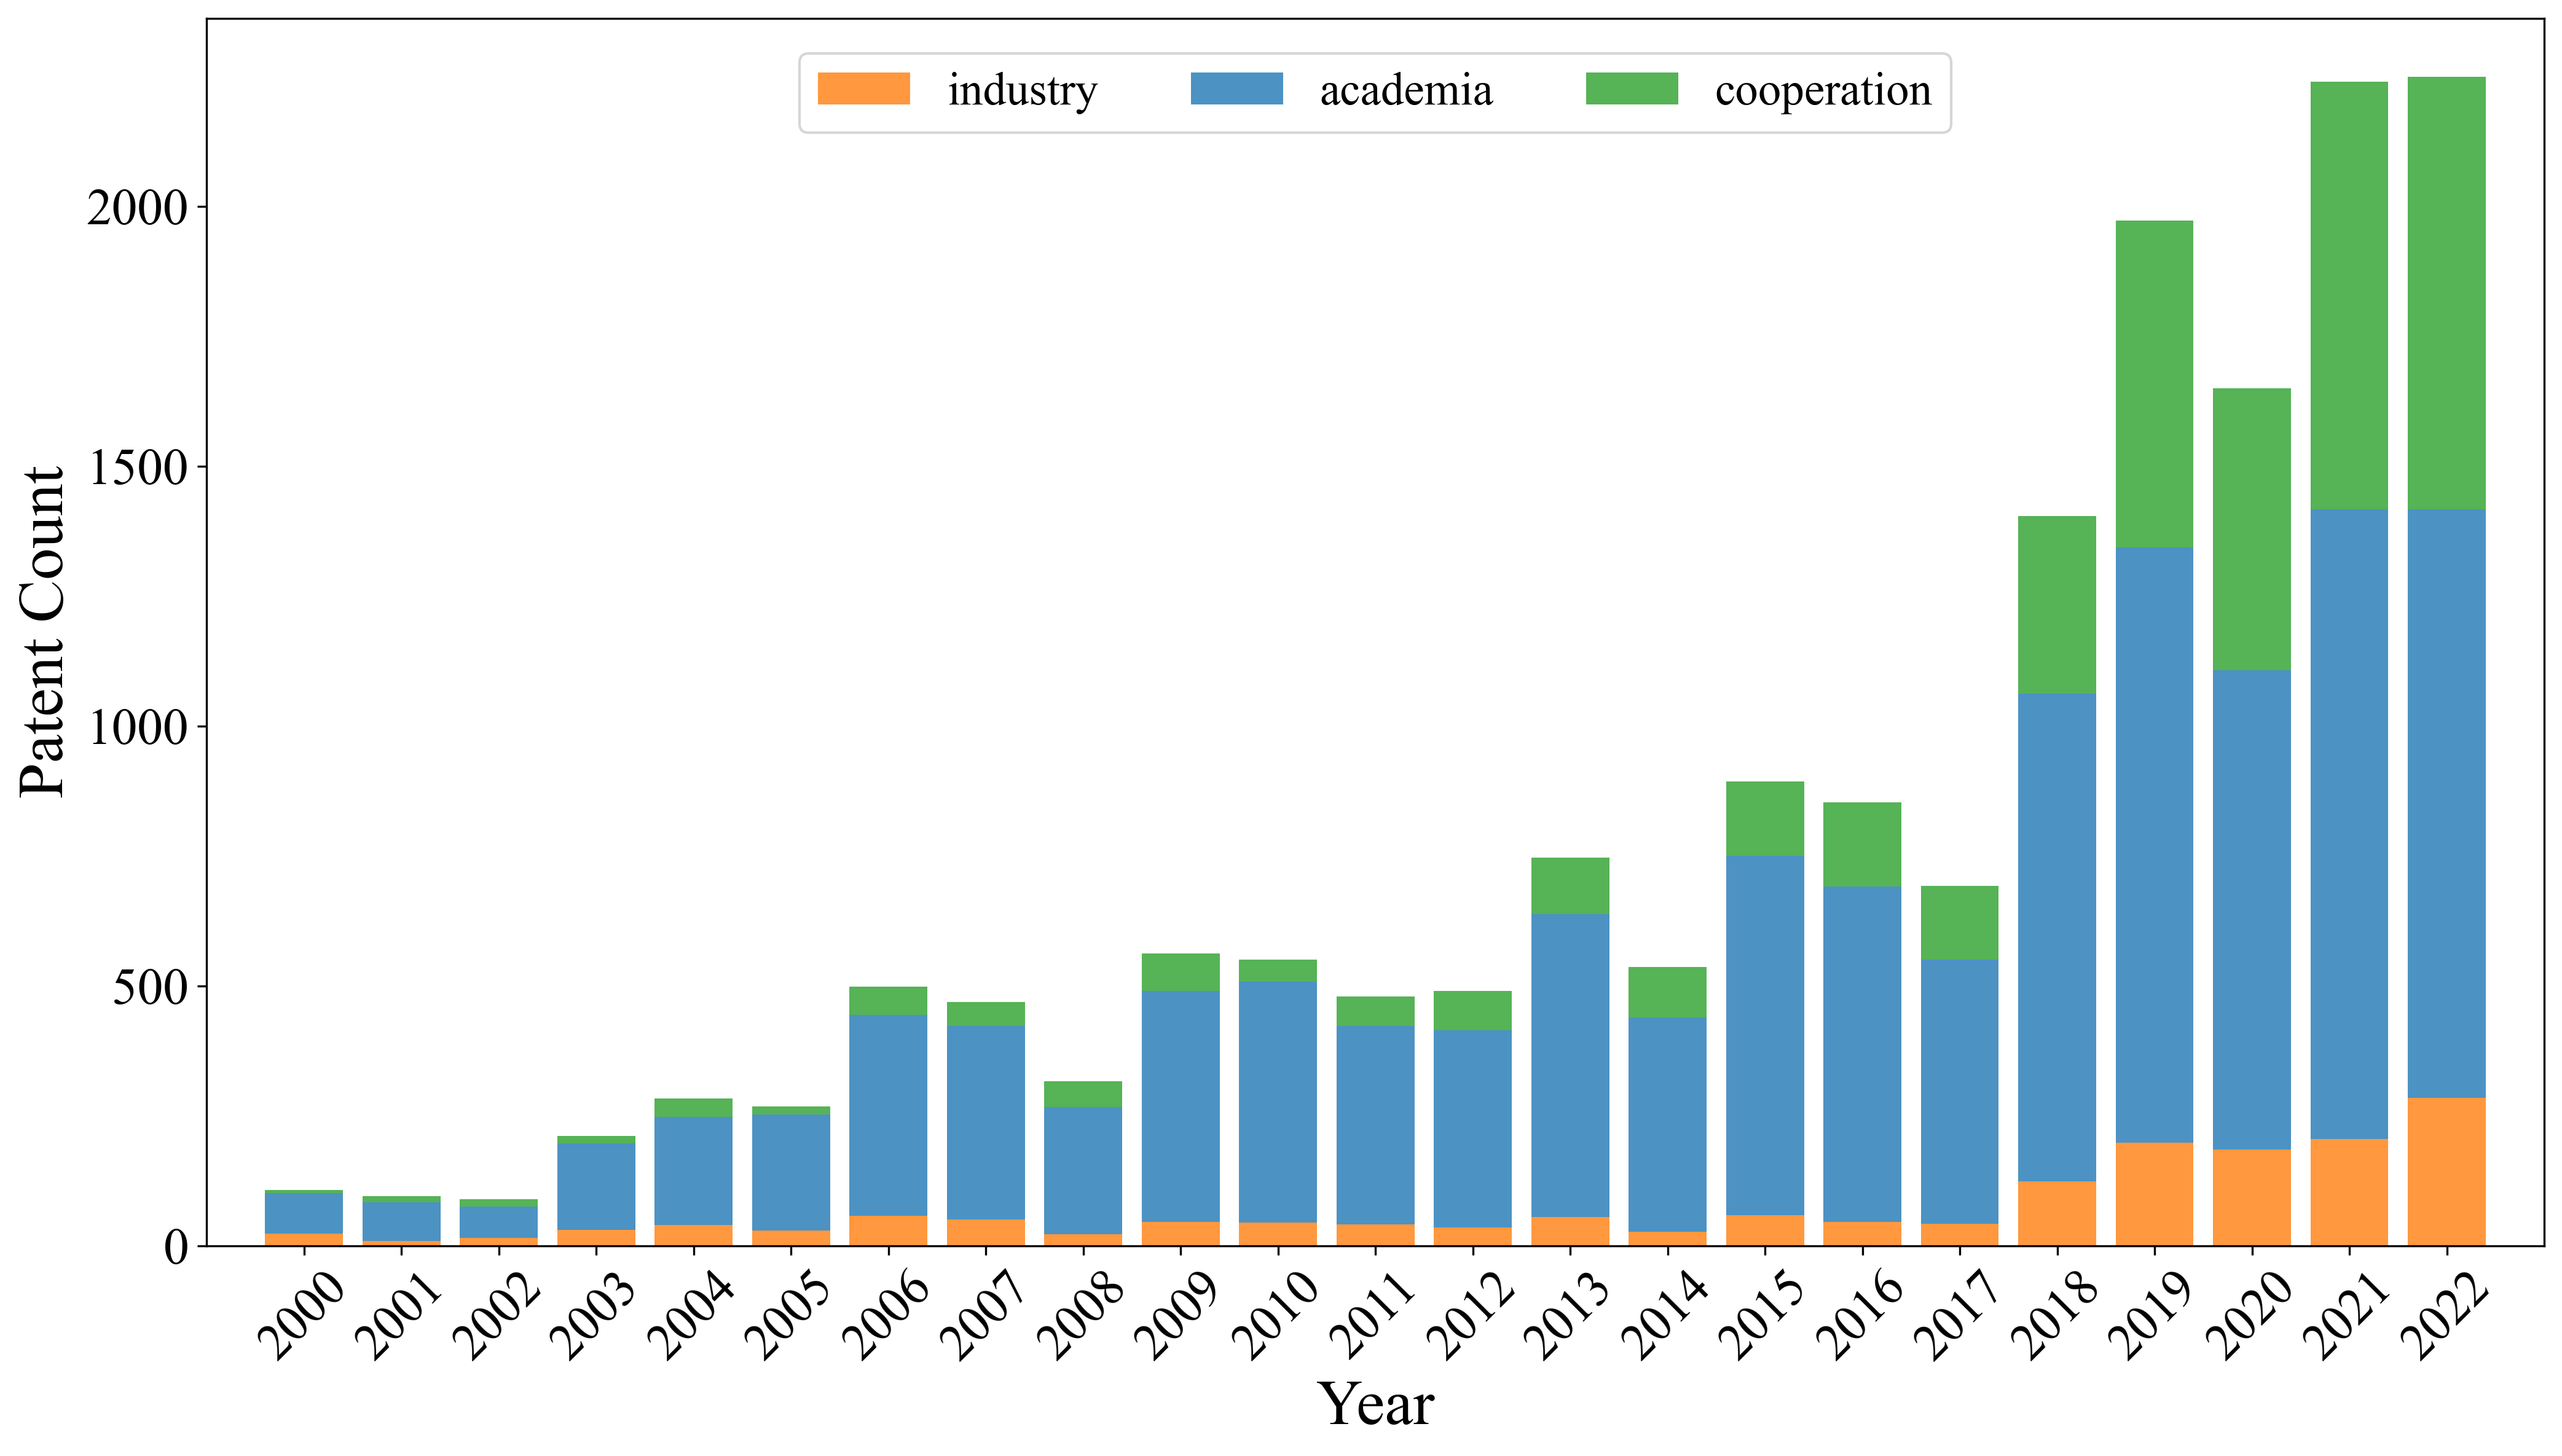

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler

# 创建一个空的列表来存储每个专利的年份和合作类型
records = []

# 遍历数据并提取年份和合作类型
for patent_id, patent_info in paper_affiliation_entity.items():
    year = patent_info['year']
    cooperation_type = patent_info['Cooperation type']
    records.append({'year': year, 'cooperation_type': cooperation_type})

# 将列表转换为 DataFrame
df = pd.DataFrame(records)

# 统计每年各个合作类型的数量
df_counts = df.groupby(['year', 'cooperation_type']).size().unstack(fill_value=0)

# 修改：确保“other”标签改为“individual”
df_counts = df_counts.rename(columns={'academic': 'academia'})

# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'

# 设置图形大小和分辨率
plt.figure(figsize=(14, 8), dpi=300)

# 使用四种颜色的配色方案，并确保industry在最底部
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ff7f0e','#1f77b4', '#2ca02c'])

# 获取所有年份
years = df_counts.index

# 绘制每种合作类型的堆叠柱状图
bottom_values = [0] * len(years)  # 初始化底部值，用于堆叠
labels = df_counts.columns  # 合作类型标签

# 遍历每个合作类型标签并绘制堆叠柱状图
for i, label in enumerate(['industry','academia','cooperation']):
    # 获取每年该合作类型的数量
    counts = df_counts[label]
    
    # 绘制柱状图
    plt.bar(years, counts, bottom=bottom_values, label=label, alpha=0.8)
    
    # 更新底部值
    bottom_values = [bottom + count for bottom, count in zip(bottom_values, counts)]

# 设置坐标轴标签和字体大小
plt.xlabel('Year', fontsize=25)
plt.ylabel('Patent Count', fontsize=25)

# 设置y轴刻度
plt.yticks(fontsize=20)
plt.xticks(years, rotation=45, fontsize=20)

# 设置图例
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=4, fontsize=18)

# 设置x轴范围
plt.xlim(min(years) - 1, max(years) + 1)

# 自动调整布局
plt.tight_layout()

# 显示图形
plt.show()

In [4]:
with open('./semantics_data/paper_entity_combinations_similarity.pickle','rb') as file:
    paper_entity_combinations_similarity = pickle.load(file)

#### Step 3 计算实体组合新颖性

In [5]:
import math
from collections import defaultdict
from itertools import combinations
from tqdm import tqdm

# 初始化存储所有独特实体的集合
paper_entity_unique = set()

# 初始化存储每篇文章或专利中实体组合概率的 defaultdict
paper_entity_combinations_probabilities = defaultdict(list)

# 遍历每篇文章，构建当前窗口的实体组合
for paper_id, entity_data in tqdm(paper_affiliation_entity.items()):
    entities = entity_data['entity']

    # 提取每种实体类型的实体列表并分别存储
    method_entities = []
    tool_entities = []
    dataset_entities = []
    
    for entity_type in ['Method','Tool','Dataset']:
        entity_list = entities.get(entity_type, [])
        
        for entity in entity_list:
            if entity:  # 如果 entity 不是空字符串
                cleaned_entity = entity.strip().strip('()')
                cleaned_entity = cleaned_entity.split('(')[0].strip().lower()  # 清理实体名
                if entity_type == 'Method':
                    method_entities.append(cleaned_entity)
                elif entity_type == 'Tool':
                    tool_entities.append(cleaned_entity)
                elif entity_type == 'Dataset':
                    dataset_entities.append(cleaned_entity)

    # 将当前文章的所有实体添加到全局唯一集合中
    paper_entity_unique.update(method_entities)
    paper_entity_unique.update(tool_entities)
    paper_entity_unique.update(dataset_entities)

    # 计算 Method 类型实体之间的两两组合并计算其概率
    for entity_pair in combinations(method_entities, 2):
        sorted_pair = tuple(sorted(entity_pair))
        
        # 查找组合的相似度
        if sorted_pair in paper_entity_combinations_similarity:
            similarity = paper_entity_combinations_similarity[sorted_pair]['similarity']
        else:
            print('出错了')

        # 存储该文章的实体组合及其概率
        paper_entity_combinations_probabilities[paper_id].append(1 - similarity)

    # 计算 Tool 类型实体之间的两两组合并计算其概率
    for entity_pair in combinations(tool_entities, 2):
        sorted_pair = tuple(sorted(entity_pair))
        
        # 查找组合的相似度
        if sorted_pair in paper_entity_combinations_similarity:
            similarity = paper_entity_combinations_similarity[sorted_pair]['similarity']
        else:
            print('出错了')

        # 存储该文章的实体组合及其概率
        paper_entity_combinations_probabilities[paper_id].append(1 - similarity)

    # 计算 Dataset 类型实体之间的两两组合并计算其概率
    for entity_pair in combinations(dataset_entities, 2):
        sorted_pair = tuple(sorted(entity_pair))
        
        # 查找组合的相似度
        if sorted_pair in paper_entity_combinations_similarity:
            similarity = paper_entity_combinations_similarity[sorted_pair]['similarity']
        else:
            print('出错了')

        # 存储该文章的实体组合及其概率
        paper_entity_combinations_probabilities[paper_id].append(1 - similarity)

100%|██████████| 17783/17783 [00:06<00:00, 2817.83it/s]


In [6]:
similarities = [similarity for values in paper_entity_combinations_probabilities.values() for similarity in values]

ninetenth_percentile = np.percentile(similarities, 90)

print(f"90th percentile of similarities: {ninetenth_percentile:.4f}")

90th percentile of similarities: 0.4542


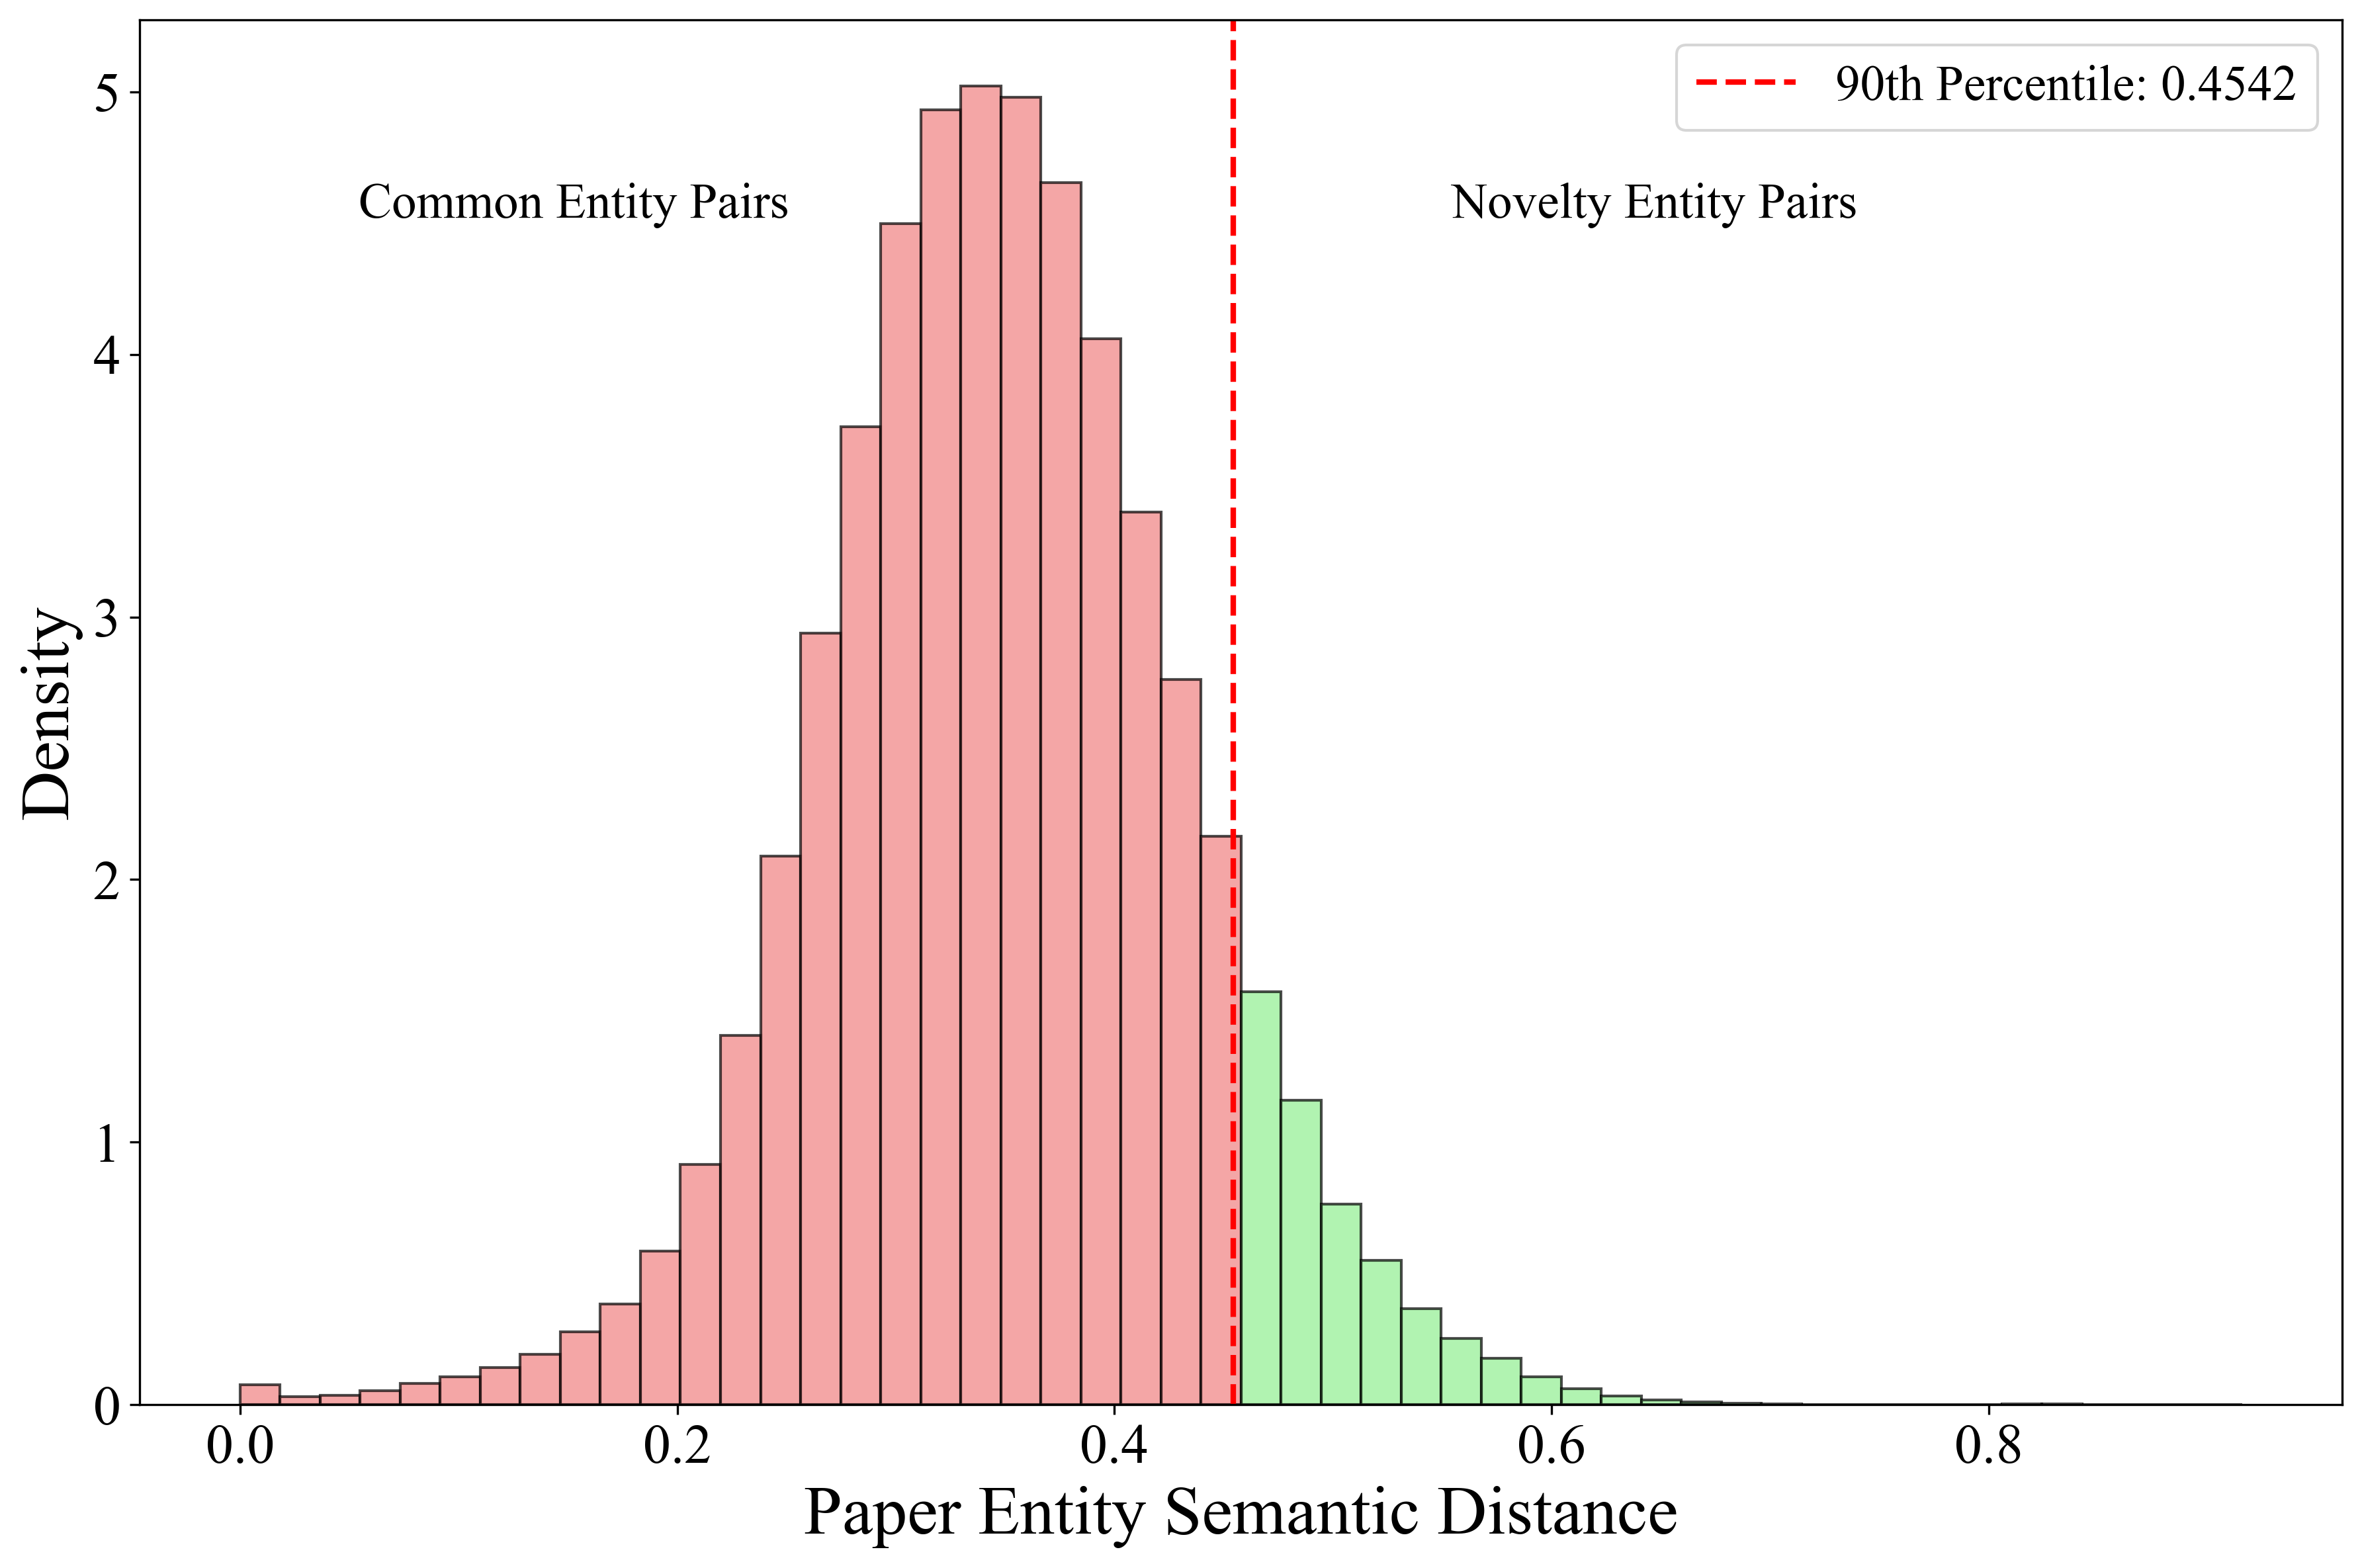

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8), dpi=300)

# 计算直方图，设置 density=False 表示频次
n, bins, patches = plt.hist(similarities, bins=50, color='skyblue', edgecolor='black', alpha=0.7, density=True)

# 填充左右两边不同颜色
for i in range(len(patches)):
    # 根据 90th 百分位数来判断颜色
    if bins[i] < ninetenth_percentile - 0.01:
        patches[i].set_facecolor('lightcoral')  # 左侧使用 lightcoral
    else:
        patches[i].set_facecolor('lightgreen')  # 右侧使用 lightgreen

# 添加竖线表示 90th 百分位数
plt.axvline(ninetenth_percentile, color='r', linestyle='dashed', linewidth=2, label=f'90th Percentile: {ninetenth_percentile:.4f}')

# 添加标题和标签
plt.xlabel('Paper Entity Semantic Distance', fontsize=25)
plt.ylabel('Density', fontsize=25)

# 设置字体大小
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# 添加文本标签
plt.text(x=ninetenth_percentile - 0.4, y=max(n) * 0.9, s="Common Entity Pairs", fontsize=18, color='black')
plt.text(x=ninetenth_percentile + 0.1, y=max(n) * 0.9, s="Novelty Entity Pairs", fontsize=18, color='black')

# 添加图例
plt.legend(fontsize=18)

# 显示图形
plt.tight_layout()
plt.show()

#### Step 4 测度文章新颖性

In [8]:
import math
import numpy as np

paper_novelty_scores = {}

for paper_id, similarities in paper_entity_combinations_probabilities.items():
    low_similarity_count = sum(1 for sim in similarities if sim > ninetenth_percentile)
    total_similarities = len(similarities)
    if total_similarities <= 25:
        continue

    novelty_score = (low_similarity_count/total_similarities)# 结合新颖性和组合长度平衡
    
    # 存储每篇论文的新颖性分数
    paper_novelty_scores[paper_id] = novelty_score

#### Step 6 Stata 部分

In [30]:
import pandas as pd

# 假设您的数据已经在df中
data = []
for paper_id, entity_data in paper_affiliation_entity.items():
    year = entity_data['year']
    affiliations = entity_data['affiliation']
    # 计算每篇论文的机构数量
    institution_count = len(set(affiliations))
    
    # 获取该论文的新颖性得分
    novelty_score = paper_novelty_scores.get(paper_id, 0)
    
    # 获取该论文的机构类型，假设是 'academic'、'cooperation' 或 'industry'
    institution_type = entity_data.get('Cooperation type', 'other')
    
    data.append({
        'paper_id': paper_id,
        'year': year,
        'institution_type': institution_type,
        'novelty_score': novelty_score,
        'institution_count': institution_count
    })

df = pd.DataFrame(data)

# 按年份分组并为每组计算前10%的新颖性得分
df['is_top_10_percent'] = df.groupby('year')['novelty_score'].transform(
    lambda x: x >= x.quantile(0.9)
).astype(int)

In [31]:
df

,paper_id,year,institution_type,novelty_score,institution_count,is_top_10_percent
0,2020.acl-demos.1,2020,academic,0.197183,12,1
1,2020.acl-demos.10,2020,academic,0.319149,2,1
2,2020.acl-demos.11,2020,cooperation,0.053073,4,0
3,2020.acl-demos.12,2020,industry,0.075342,1,0
4,2020.acl-demos.13,2020,academic,0.048387,1,0
...,...,...,...,...,...,...
17778,2022.emnlp-tutorials.2,2022,academic,0.000000,1,0
17779,2022.emnlp-tutorials.3,2022,academic,0.080460,1,0
17780,2022.emnlp-tutorials.4,2022,cooperation,0.136986,3,0
17781,2022.emnlp-tutorials.5,2022,cooperation,0.170455,2,0


In [32]:
# 过滤other
df = df[df['institution_type'] != 'other']
df

,paper_id,year,institution_type,novelty_score,institution_count,is_top_10_percent
0,2020.acl-demos.1,2020,academic,0.197183,12,1
1,2020.acl-demos.10,2020,academic,0.319149,2,1
2,2020.acl-demos.11,2020,cooperation,0.053073,4,0
3,2020.acl-demos.12,2020,industry,0.075342,1,0
4,2020.acl-demos.13,2020,academic,0.048387,1,0
...,...,...,...,...,...,...
17778,2022.emnlp-tutorials.2,2022,academic,0.000000,1,0
17779,2022.emnlp-tutorials.3,2022,academic,0.080460,1,0
17780,2022.emnlp-tutorials.4,2022,cooperation,0.136986,3,0
17781,2022.emnlp-tutorials.5,2022,cooperation,0.170455,2,0


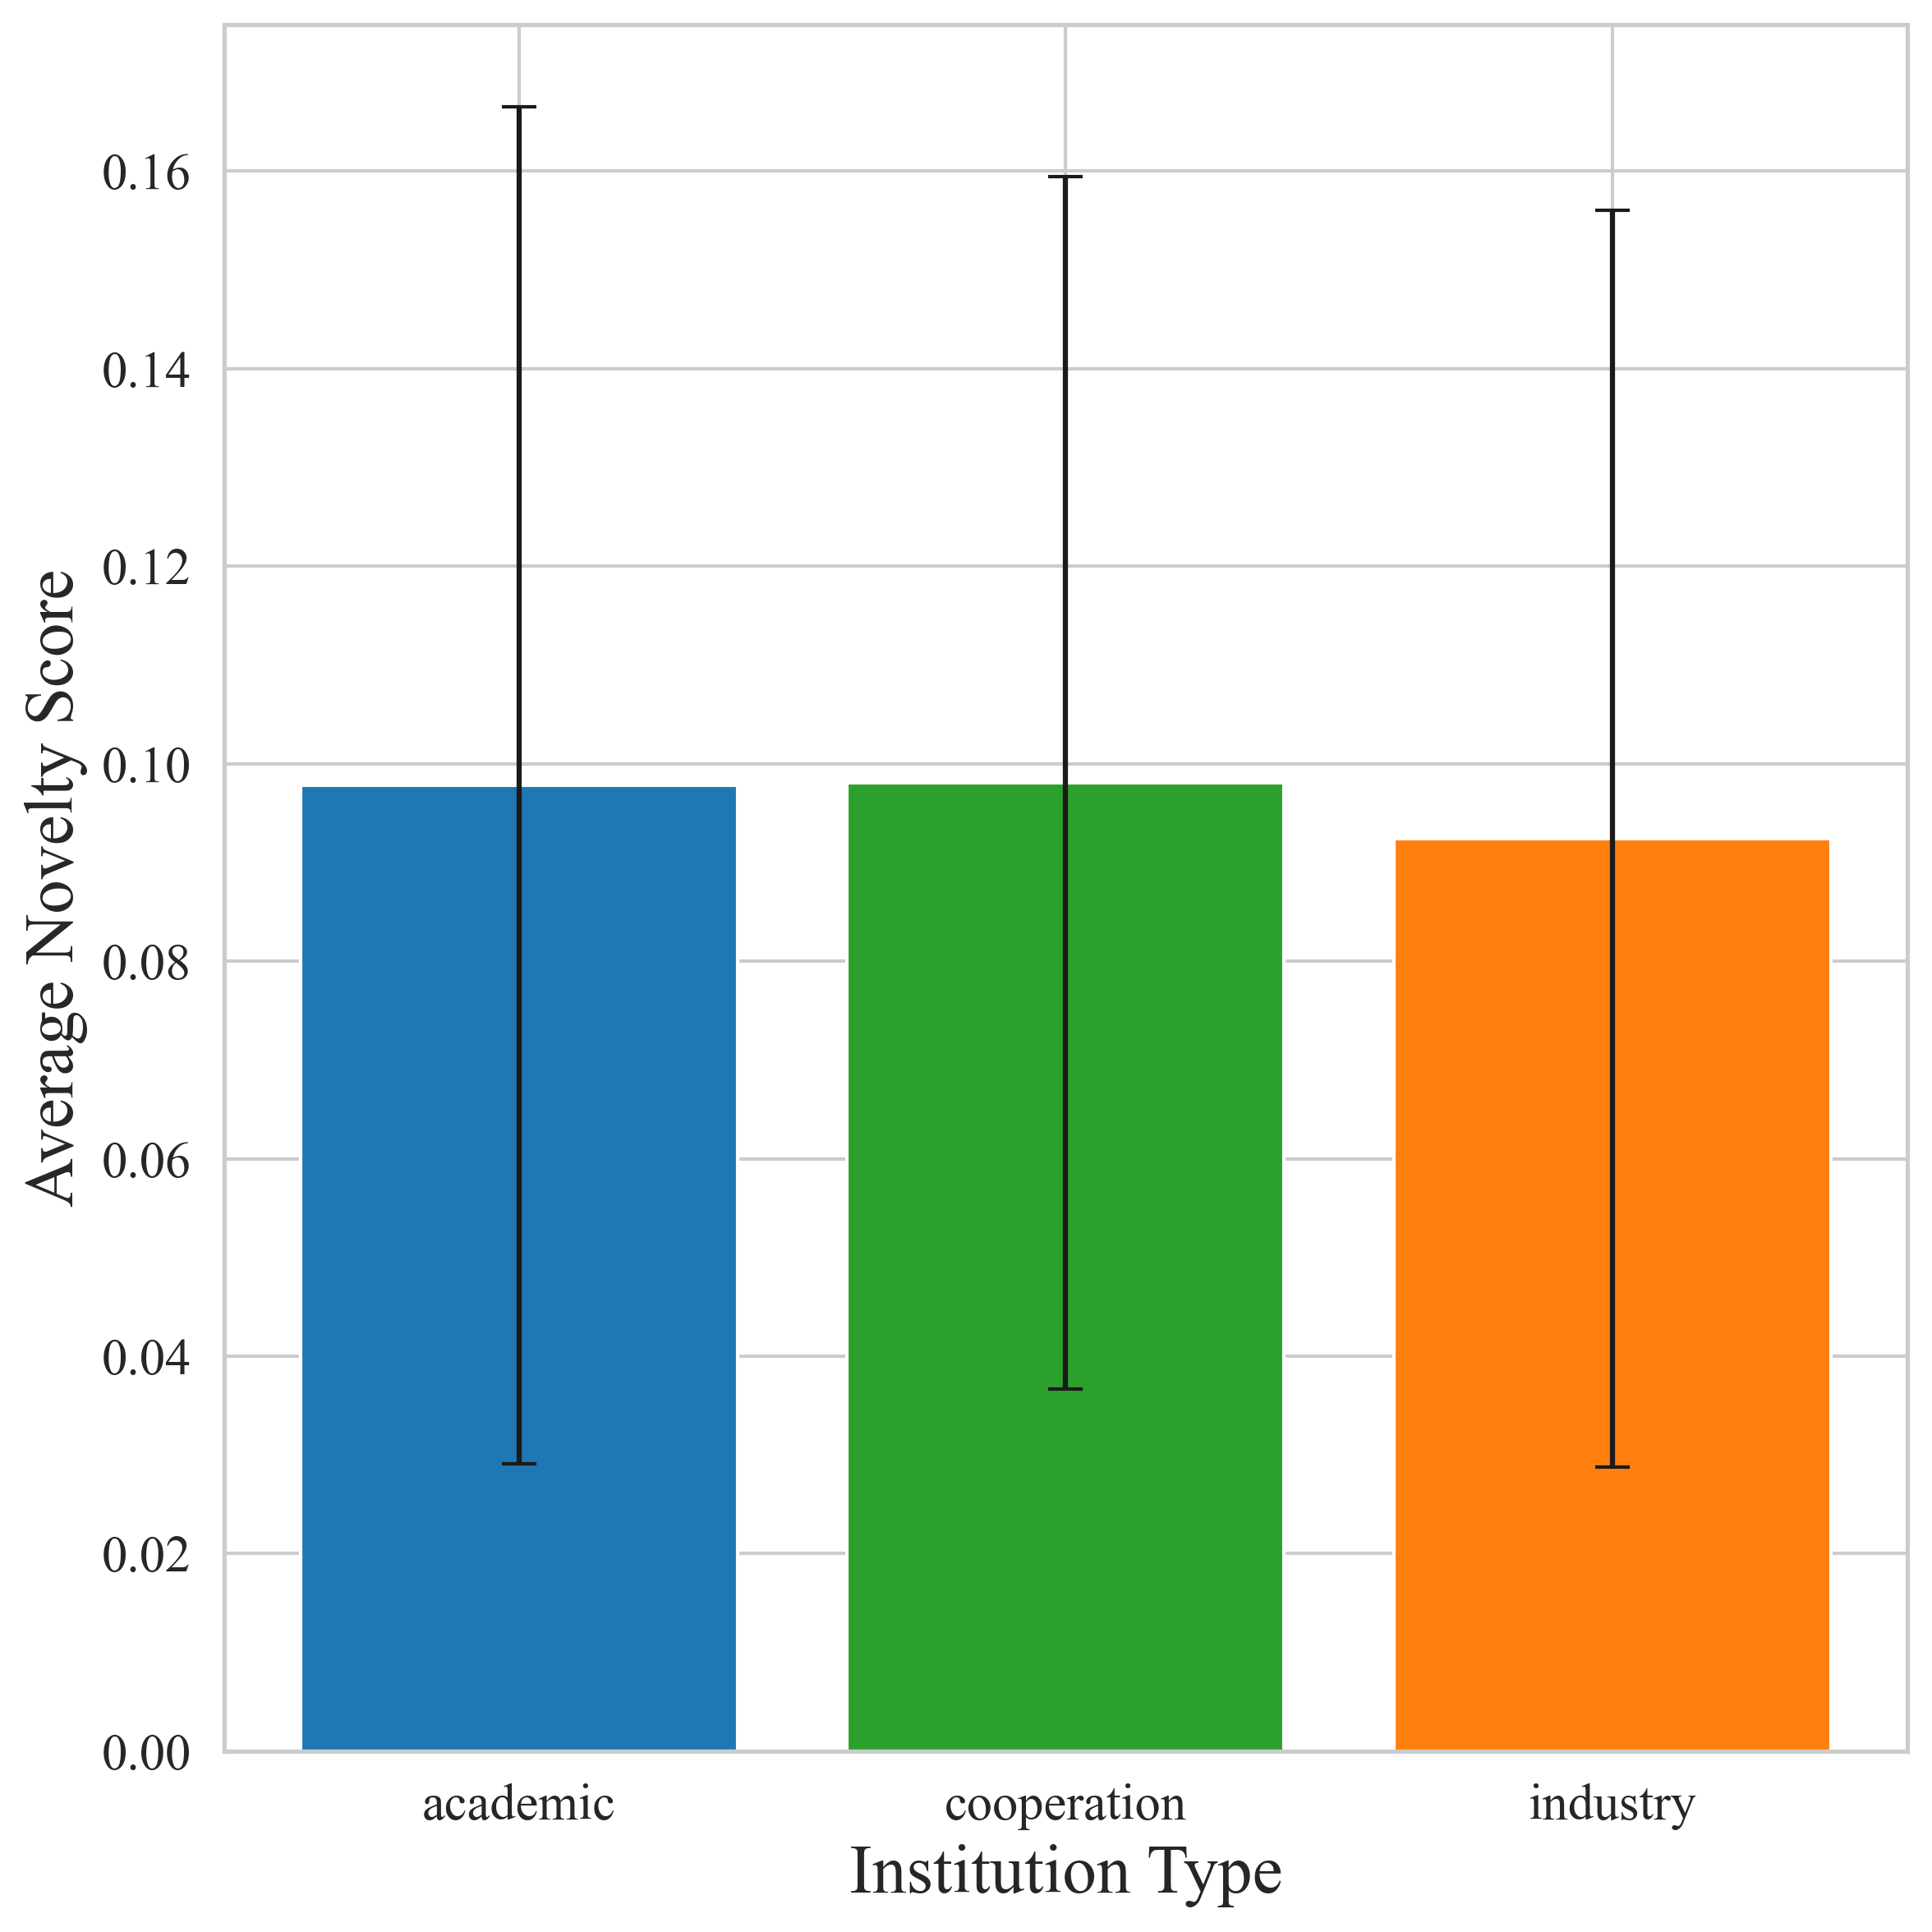

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from cycler import cycler  # 导入cycler函数

# 假设 df 是您已经处理的数据框

# 按照 'institution_type' 分组并计算每个组的平均 novelty_score 和标准差
avg_novelty_scores = df.groupby('institution_type')['novelty_score'].agg(['mean', 'std']).reset_index()

# 创建一个绘图风格
sns.set(style="whitegrid", font="Times New Roman")

# 设置自定义颜色配色方案
palette = ['#1f77b4', '#2ca02c','#ff7f0e']

# 创建柱状图并添加误差线
plt.figure(figsize=(8, 8), dpi=300)

# 手动为每个柱子指定颜色
colors = plt.cm.Set2(np.linspace(0, 1, len(avg_novelty_scores)))  # 使用Set2调色板

bars = plt.bar(avg_novelty_scores['institution_type'], avg_novelty_scores['mean'], 
               yerr=avg_novelty_scores['std'], color=palette,capsize=5, label='Average Novelty Score')

plt.xlabel('Institution Type', fontsize=20)
plt.ylabel('Average Novelty Score', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# 显示图形
plt.tight_layout()
plt.show()

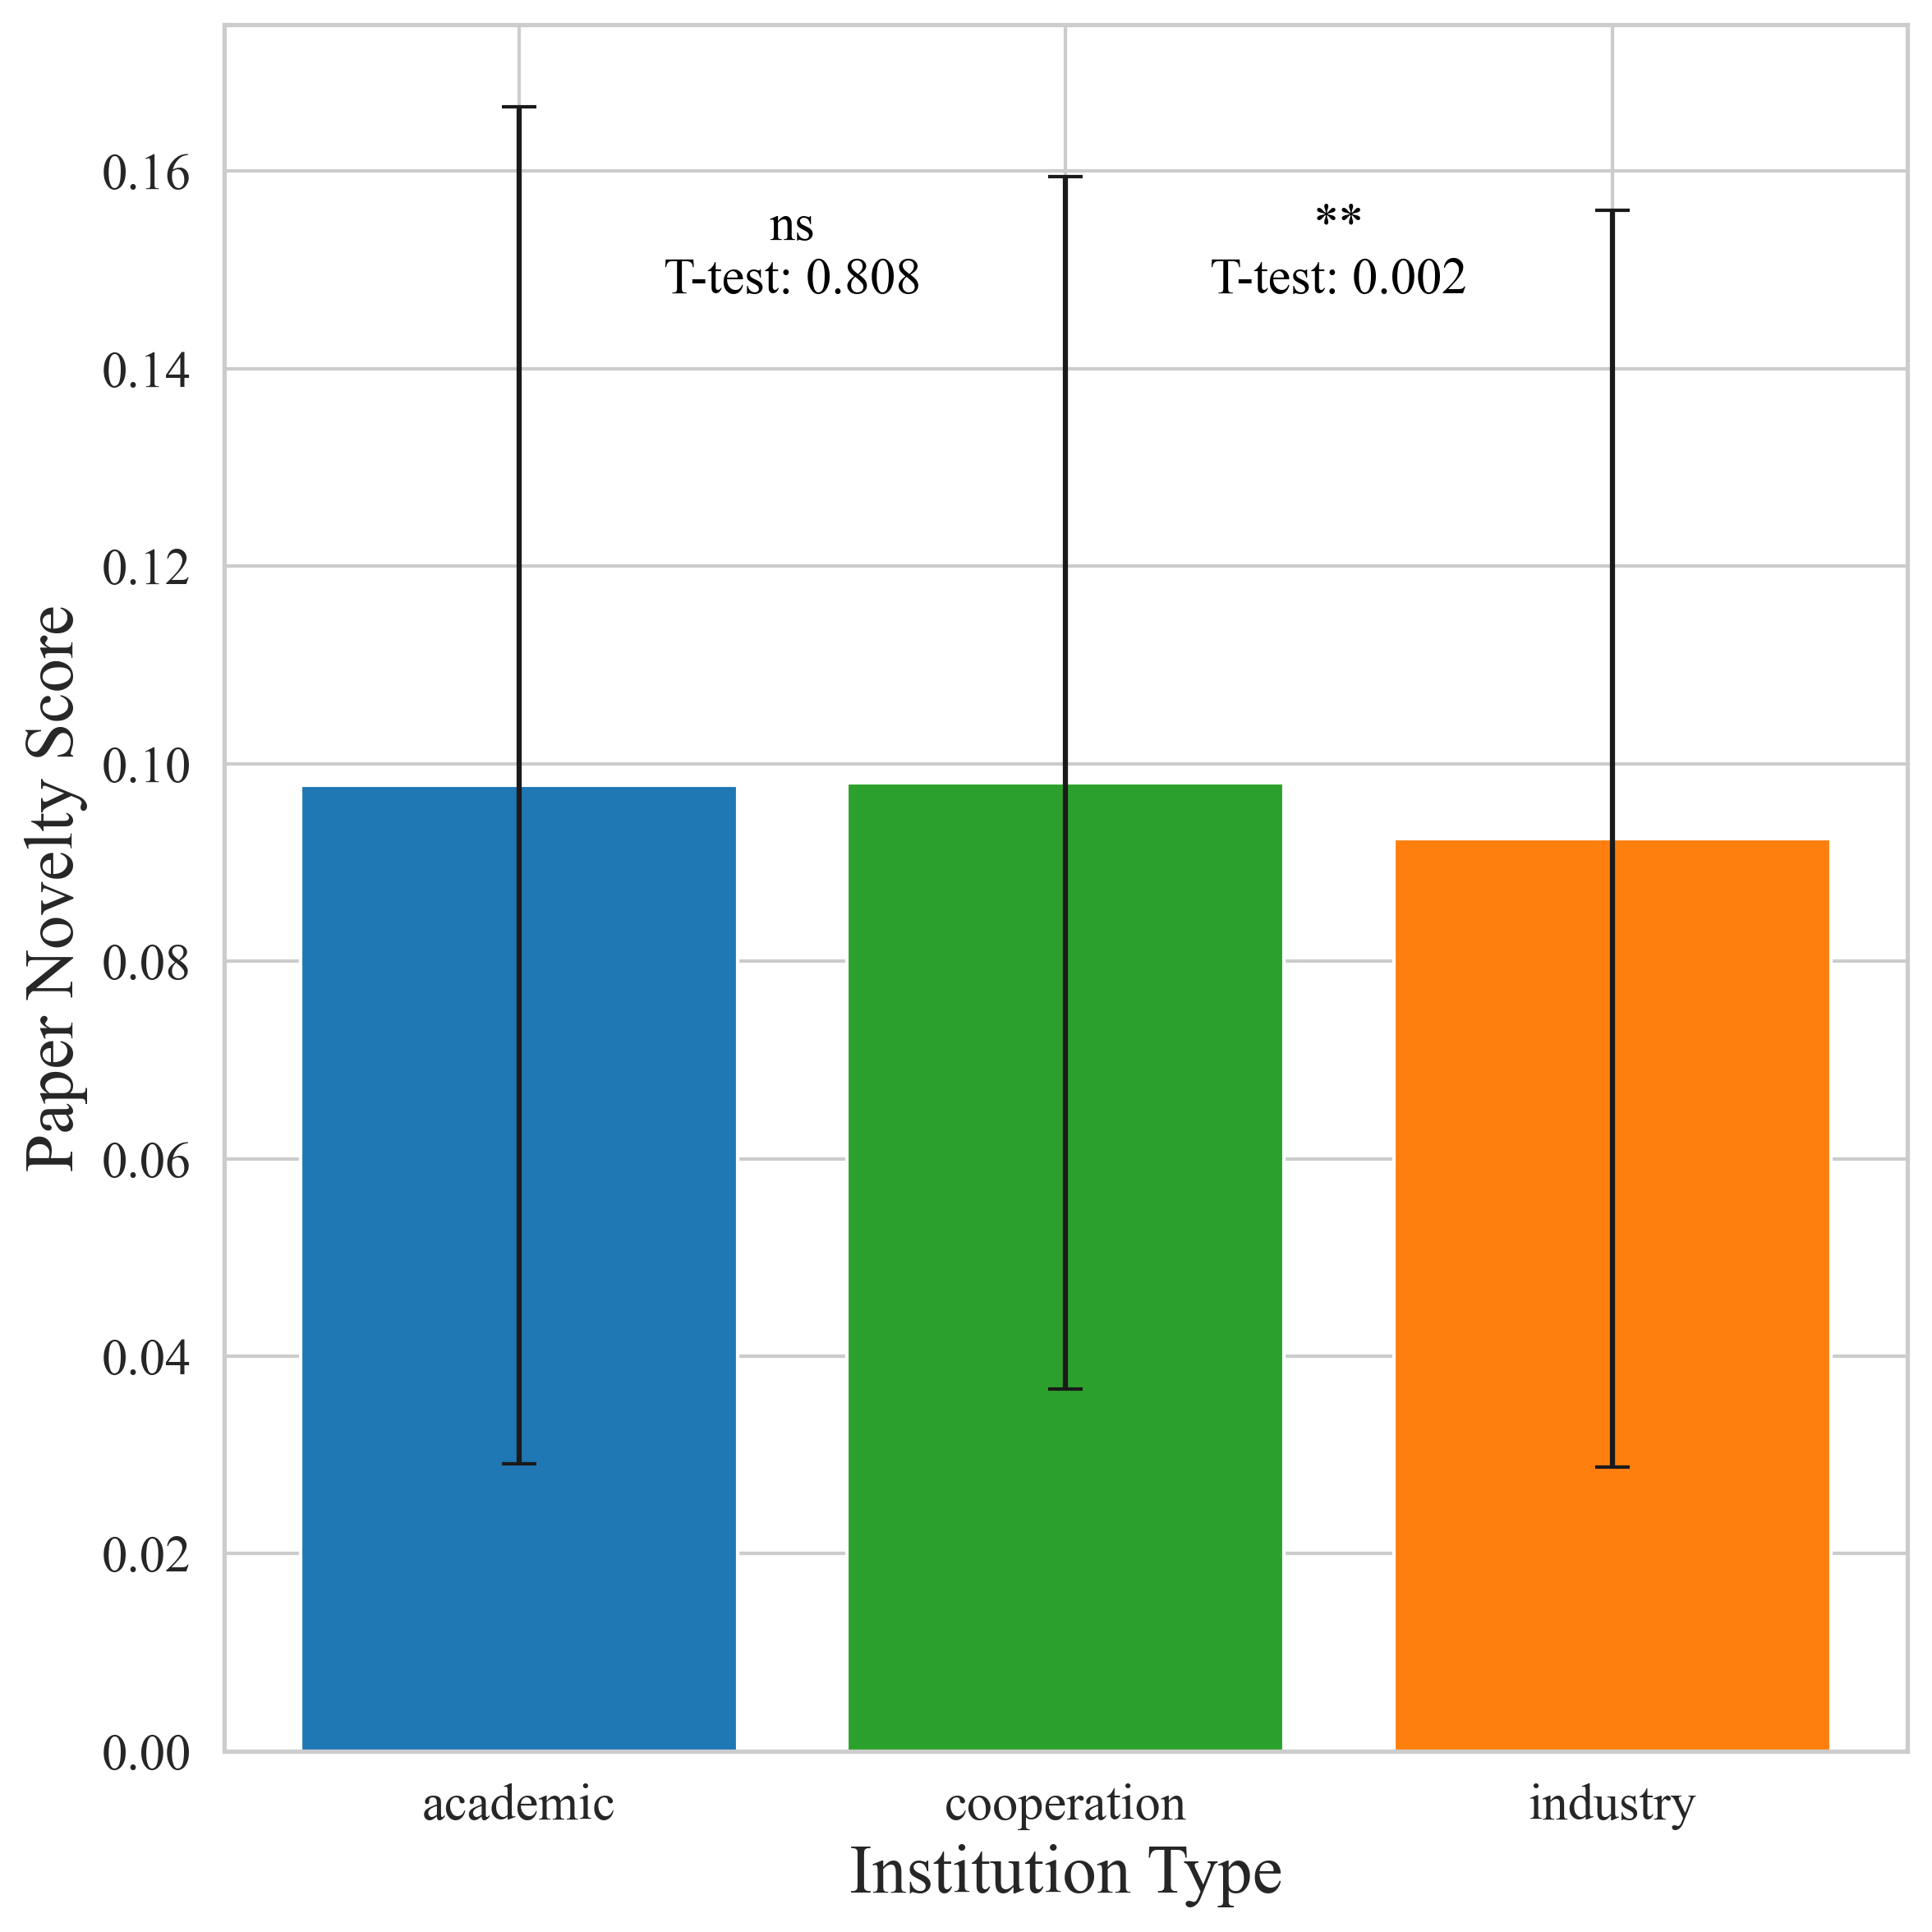

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from cycler import cycler  # 导入cycler函数

# 假设 df 是您已经处理的数据框

# 按照 'institution_type' 分组并计算每个组的平均 novelty_score 和标准差
avg_novelty_scores = df.groupby('institution_type')['novelty_score'].agg(['mean', 'std']).reset_index()

# 创建一个绘图风格
sns.set(style="whitegrid", font="Times New Roman")

# 设置自定义颜色配色方案
palette = ['#1f77b4', '#2ca02c','#ff7f0e']

# 创建柱状图并添加误差线
plt.figure(figsize=(8, 8), dpi=300)

# 绘制柱状图并添加误差线
bars = plt.bar(avg_novelty_scores['institution_type'], avg_novelty_scores['mean'], 
               yerr=avg_novelty_scores['std'], color=palette, capsize=5, label='Average Novelty Score')

# 添加显著性星号
# 比较第一组和第二组
group_1 = df[df['institution_type'] == avg_novelty_scores['institution_type'][0]]['novelty_score']
group_2 = df[df['institution_type'] == avg_novelty_scores['institution_type'][1]]['novelty_score']
t_stat_1_2, p_val_1_2 = stats.ttest_ind(group_1, group_2)

# 比较第二组和第三组
group_3 = df[df['institution_type'] == avg_novelty_scores['institution_type'][2]]['novelty_score']
t_stat_2_3, p_val_2_3 = stats.ttest_ind(group_2, group_3)

# 根据 p 值添加星号
def get_significance(p_val):
    if p_val < 0.01:
        return '**'
    elif p_val < 0.05:
        return '*'
    else:
        return 'ns'

# 获取y轴的最大值，留白空间
y_max = max(avg_novelty_scores['mean'] + avg_novelty_scores['std'])  

# 在柱状图之间添加显著性标注
# 第一组和第二组之间
plt.text(0.5, y_max-0.02, f'{get_significance(p_val_1_2)}\nT-test: {p_val_1_2:.3f}', ha='center', va='bottom', fontsize=15, color='black')
# 第二组和第三组之间
plt.text(1.5, y_max-0.02, f'{get_significance(p_val_2_3)}\nT-test: {p_val_2_3:.3f}', ha='center', va='bottom', fontsize=15, color='black')

plt.xlabel('Institution Type', fontsize=20)
plt.ylabel('Paper Novelty Score', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# 显示图形
plt.tight_layout()
plt.show()

#### Step 5 构造dummy 变量

In [21]:
df['institution_type'] = pd.Categorical(df['institution_type'], categories=['industry', 'academic', 'cooperation','oth'], ordered=False)
df = pd.get_dummies(df, columns=['institution_type'], drop_first=True)  # 以 'industry' 作为基准组

In [23]:
df['institution_type_academic'] = df['institution_type_academic'].apply(lambda x: 1 if x == True else 0)
df['institution_type_cooperation'] = df['institution_type_cooperation'].apply(lambda x: 1 if x == True else 0)

In [26]:
# 合并作者数量信息
author_numbers = pd.read_excel('E:/DeskTopE/ACL_authors.xlsx')
author_numbers['authors_num'] = author_numbers['authors'].apply(
    lambda x: len(x.split(',')) if isinstance(x, str) and x else 0
)
df = df.merge(author_numbers[['paper_id', 'authors_num']], on='paper_id', how='left')

In [27]:
df.to_excel('./result/paper_novelty_stata.xlsx',index=False)

#### Step 7 变量间的相关性

<Figure size 3600x3600 with 0 Axes>

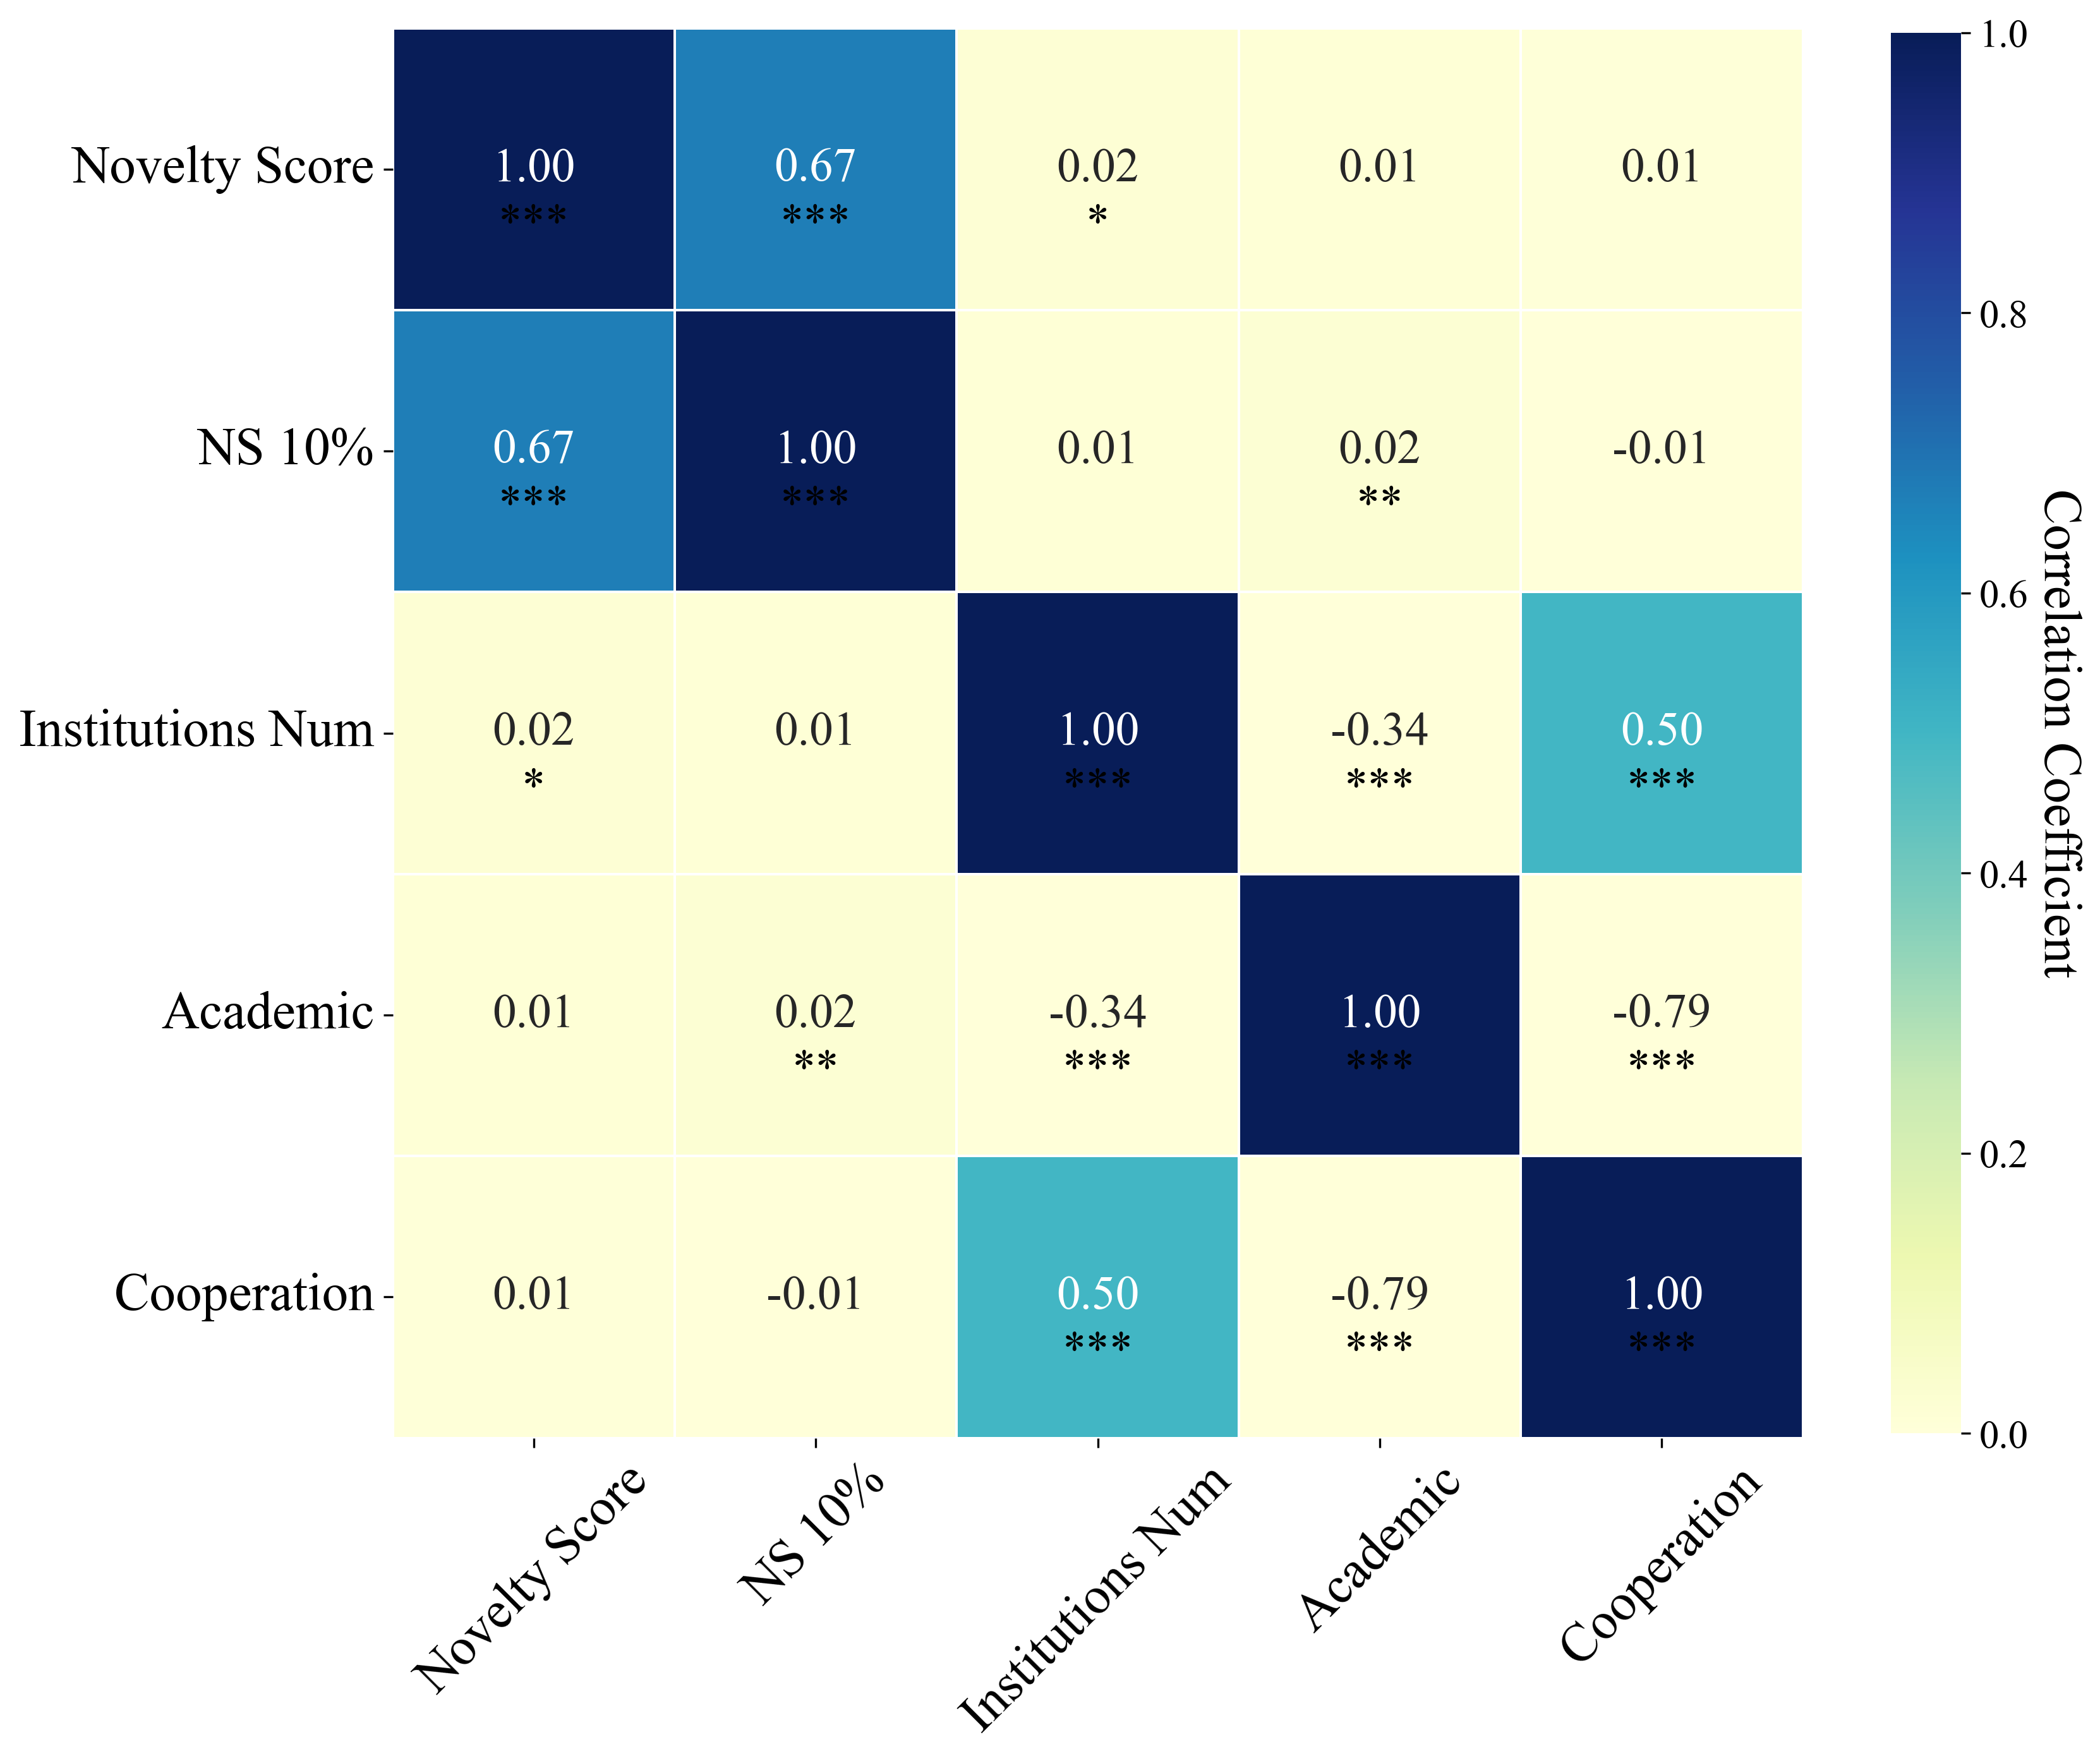

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

# 删除包含 NaN 的行
df_cleaned = df[['novelty_score', 'is_top_10_percent', 'institution_count', 
                 'institution_type_academic', 'institution_type_cooperation']].dropna()

# 计算相关性矩阵
correlation_matrix = df_cleaned.corr()

# 计算 p 值矩阵
p_values = np.ones_like(correlation_matrix, dtype=float)
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        _, p_values[i, j] = pearsonr(df_cleaned.iloc[:, i], df_cleaned.iloc[:, j])

# 将 p 值转换为星号表示
p_star_matrix = np.full_like(correlation_matrix, '', dtype=object)
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        p_val = p_values[i, j]
        if p_val < 0.001:
            p_star_matrix[i, j] = '***'
        elif p_val < 0.01:
            p_star_matrix[i, j] = '**'
        elif p_val < 0.05:
            p_star_matrix[i, j] = '*'
        else:
            p_star_matrix[i, j] = 'n.s.'

# 创建热图
plt.figure(figsize=(12, 12),dpi=300)

# 自定义横纵坐标名
column_names = ['Novelty Score', 'NS 10%', 'Institutions Num','Academic', 'Cooperation']

# 创建热图
plt.figure(figsize=(12, 12), dpi=300)

# 绘制相关性热图（只显示相关性系数）
ax = sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', square=True, fmt='.2f', linewidths=0.5, cbar_kws={'shrink': .8}, annot_kws={'size': 18},
            xticklabels=column_names, yticklabels=column_names,vmin=0, vmax=1.0)

# 在相关性值下方显示星号矩阵
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        if p_star_matrix[i, j] != 'n.s.':  # 只有显著性星号才显示
            plt.text(j + 0.5, i + 0.7, p_star_matrix[i, j], ha='center', va='center', fontsize=18, color='black')


# 添加相关系数色块条标签
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)  # 这里设置字体大小为10，
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20, size=20)


# 旋转横坐标标签 45°
plt.xticks(rotation=45,fontsize=20)
plt.yticks(rotation=0,fontsize=20)

# 显示图像
plt.show()